# Feature Extraction (Transfer Learning: Method 1)

We can train our own model but using convolution layers of pretrained models.


In this approach, the weights of the pre-trained convolutional base are frozen (non-trainable). The base model acts as a fixed feature extractor, and only the newly added top classifier layers are trained on the new dataset. This is typically used when you have a small new dataset that is similar to the original pre-training data (like ImageNet)

# Loading our own dataset

In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download ankit1743/skyview-an-aerial-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/ankit1743/skyview-an-aerial-landscape-dataset
License(s): CC0-1.0
  0% 0.00/154M [00:00<?, ?B/s]
100% 154M/154M [00:00<00:00, 1.62GB/s]


In [2]:
!unzip -q skyview-an-aerial-landscape-dataset.zip -d skyview

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from keras.utils import image_dataset_from_directory

dataset_path = "/content/skyview/Aerial_Landscapes"
image_size = (224,224)
batch_size = 32

train_ds = image_dataset_from_directory(
    directory = dataset_path,
    labels = "inferred",
    label_mode= "categorical",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split = 0.2,
    subset = "training",
    verbose= True
)
validation_ds = image_dataset_from_directory(
    directory = dataset_path,
    labels = "inferred",
    label_mode= "categorical",
    color_mode = "rgb",
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    validation_split= 0.2,
    subset = "validation",
    verbose= True
)


Found 12000 files belonging to 15 classes.
Using 9600 files for training.
Found 12000 files belonging to 15 classes.
Using 2400 files for validation.


In [4]:
train_ds.class_names

['Agriculture',
 'Airport',
 'Beach',
 'City',
 'Desert',
 'Forest',
 'Grassland',
 'Highway',
 'Lake',
 'Mountain',
 'Parking',
 'Port',
 'Railway',
 'Residential',
 'River']

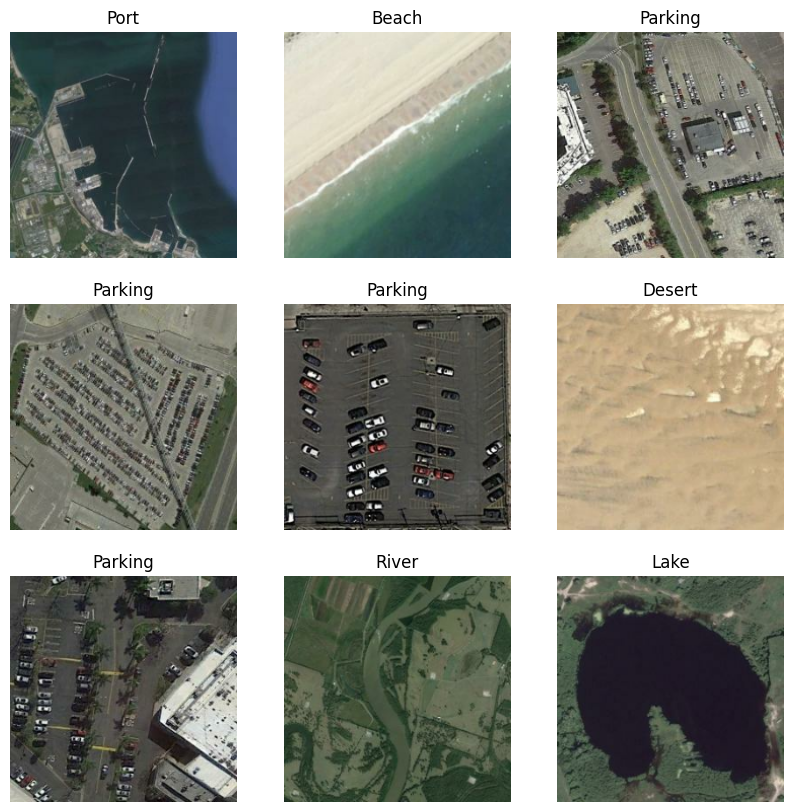

In [5]:
plt.figure( figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint"))
    plt.title(train_ds.class_names[ np.argmax(labels[i])])
    plt.axis("off")

# Load the Pretrained model & Our Dense Layers

In [6]:
from keras.applications import VGG16

backbone = VGG16(
    input_shape = (224,224,3),
    include_top = False,
    weights = "imagenet"
)

backbone.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from keras.models import Sequential

model = Sequential()

backbone.trainable = False # Make the backbone layer weights non- trainable.

model.add(Input(shape = (224, 224, 3)))
model.add(backbone) # Pretrained
model.add(GlobalAveragePooling2D())

# Dense Layers
model.add(Dense(128, activation= "relu"))
model.add(Dropout(0.2))

model.add(Dense(64, activation= "relu"))
model.add(Dropout(0.1))

model.add(Dense(15, activation= "softmax")) # output layer

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,583 (56.42 MB)

 Trainable params: 74,895 (292.56 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
model.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy", "f1_score"]
)
history = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = 10
)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 79s 207ms/step - accuracy: 0.4541 - f1_score: 0.4507 - loss: 2.1922 - val_accuracy: 0.8554 - val_f1_score: 0.8568 - val_loss: 0.4588
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 60s 201ms/step - accuracy: 0.8276 - f1_score: 0.8260 - loss: 0.5661 - val_accuracy: 0.8829 - val_f1_score: 0.8835 - val_loss: 0.3708
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - accuracy: 0.8779 - f1_score: 0.8769 - loss: 0.3906 - val_accuracy: 0.8979 - val_f1_score: 0.8983 - val_loss: 0.3326
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - accuracy: 0.8946 - f1_score: 0.8941 - loss: 0.3295 - val_accuracy: 0.9029 - val_f1_score: 0.9037 - val_loss: 0.3062
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 61s 202ms/step - accuracy: 0.9151 - f1_score: 0.9142 - loss: 0.2601 - val_accuracy: 0.9142 - val_f1_score: 0.9147 - val_loss: 0.2948
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 83s 206ms/step - accuracy: 0.9225 - f1_score: 0.9217 - loss: 0.2282 - val_accuracy: 0.9158 - va

In [11]:
history.history

{'accuracy': [0.6312500238418579,
  0.8384374976158142,
  0.8807291388511658,
  0.8989583253860474,
  0.9164583086967468,
  0.9229166507720947,
  0.9365624785423279,
  0.9434375166893005,
  0.9465625286102295,
  0.9470833539962769],
 'f1_score': [<tf.Tensor: shape=(15,), dtype=float32, numpy=
  array([0.7088036 , 0.44495407, 0.62665623, 0.56697816, 0.6752873 ,
         0.74919087, 0.6599326 , 0.5961089 , 0.49568215, 0.7257447 ,
         0.74404305, 0.671521  , 0.5526931 , 0.6911315 , 0.54838705],
        dtype=float32)>,
  <tf.Tensor: shape=(15,), dtype=float32, numpy=
  array([0.9133126 , 0.684049  , 0.87306494, 0.7866043 , 0.89296633,
         0.8958652 , 0.8497652 , 0.8483896 , 0.79967016, 0.87354535,
         0.89649796, 0.8748067 , 0.70691013, 0.8835341 , 0.79342717],
        dtype=float32)>,
  <tf.Tensor: shape=(15,), dtype=float32, numpy=
  array([0.92403096, 0.7633587 , 0.91164964, 0.8360528 , 0.93220335,
         0.9227202 , 0.88473517, 0.8743168 , 0.85899514, 0.9044289 ,
    

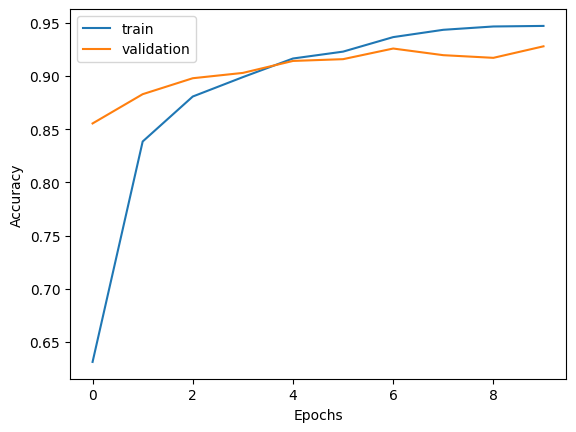

In [9]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "validation"])
plt.show()

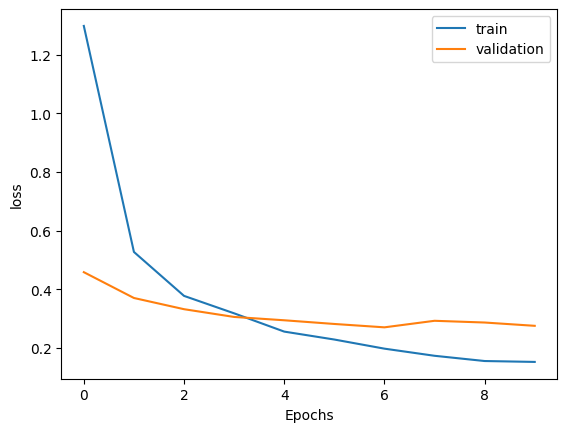

In [12]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(["train", "validation"])
plt.show()